In [ ]:
!pip install openpyxl tqdm python-docx openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
import os, re, json, glob
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
from docx import Document
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Access the API key securely from Colab's Userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
# path to input JSONs and output folder
excel_path = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Radiology-manual-annotations.xlsx"
INPUT_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Medical reports for cases/"
OUTPUT_DIR = r"/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-ver2"

# checks output directory is real
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Synonyms from PDF
SYNONYMS = {
    "speculated": "spiculated",
    "heterogenous": "heterogeneous",
    "heterogenously": "heterogeneous",
    "homogenous": "homogeneous",
    "non enhancement": "no_enhancement",
    "imln": "lymph_nodes",
    "tortous": "tortuous",
    "leisons": "lesions",
    "malibnant": "malignant",
    "suspisious": "suspicious",
    "suspicous": "suspicious",
    "benign macrocalcifications": "macrocalcification",
    "macrocalcifications": "macrocalcification",
    "microcalcification": "microcalcifications",
    "cluster": "clustered",
    "clusters": "clustered",
    "superior": "upper",
    "inferior": "lower",
    "medial": "inner",
    "lateral": "outer"
}
# Categorize primitives from PDF
CANONICALS = {
    "version": "1.0",
    "categories": {
        "suspicion_level": ["normal", "benign", "suspicious", "malignant"],
        "lesion_type": ["mass", "non_mass", "asymmetry", "architectural_distortion", "calcifications",
                       "lymph_nodes", "postoperative_change", "edema", "dilated_duct", "cyst", "adenosis",
                       "hamartoma", "vascular_calcifications", "prominent_ducts"],
        "mass_attributes": ["circumscribed", "obscured", "indistinct", "microlobulated", "spiculated",
                           "regular_rim", "partial_rim", "rim", "dark_internal_septations", "homogeneous_mass",
                           "heterogeneous_mass", "ductal_extension", "satellites"],
        "nme_pattern": ["focal", "linear", "segmental", "regional", "diffuse", "ductal", "clumped",
                       "clustered_ring", "cobblestone", "patchy", "glandular"],
        "calc_morphology": ["macrocalcification", "microcalcifications", "pleomorphic", "punctate",
                           "vascular", "linear_branching"],
        "calc_distribution": ["clustered", "segmental", "regional", "diffuse"],
        "modifiers_signs": ["nipple_retraction", "skin_retraction", "skin_thickening", "contour_bulge",
                           "air_gas", "recurrence", "surgical_clips", "flap", "portacath"],
        "extent_location": ["multiple", "multifocal", "multicentric", "axillary", "retroareolar", "central",
                           "upper", "lower", "inner", "outer", "upper_outer", "upper_inner", "lower_outer",
                           "lower_inner"]
    }
}

# Map sheet → lesion type
LESION_TYPE_MAP = {
    "mass_description": "mass",
    "distortion": "architectural_distortion",
    "postoperative": "postoperative_change",
    "postneoajuvant chemotherapy": "treatment_change",
    "asymmetry": "asymmetry",
    "calcifications": "calcifications",
    "mass enhancement_description": "mass_enhancement",
    "nonmass enhancement_description": "nonmass_enhancement",
    # "all" sheet might be mixed/general
    "all": "mixed",
}

STANDARD_RENAMES = {
    "Breast density (ACR)": "ACR",
    "Pathology Classification/ Follow up": "Pathology",
}

IMAGE_COL_CANDIDATES = ["Image_name", "Image Name", "Image_ID", "Image ID", "image_name", "image_id"]

VIEW_POSITION = {
    "CC": "top-down view",
    "MLO": "upper outer quadrant and chest muscle view"
}

DENSITY_DESCRIPTION = {
    "A": "Almost entirely fatty breast tissue.",
    "B": "Scattered fibroglandular tissue.",
    "C": "Heterogeneously dense breast tissue.",
    "D": "Extremely dense breast tissue."
}



In [ ]:
xl = pd.ExcelFile(excel_path)

frames = []
for sheet in xl.sheet_names:
    tmp = xl.parse(sheet)
    tmp["__sheet__"] = sheet  # remember which sheet the row came from
    tmp = tmp.rename(columns=STANDARD_RENAMES)
    frames.append(tmp)

df = pd.concat(frames, ignore_index=True)

print(df.columns)

Index(['Image_name', 'Patient_ID', 'Side', 'Type', 'Age', 'ACR', 'BIRADS',
       'Findings', 'View', 'Tags', 'Machine', 'Pathology', '__sheet__',
       'Abnormality type', 'Single/Multiple',
       'Mass density/enhancement pattern', 'Mass shape', 'Mass margin'],
      dtype='object')


In [ ]:
# find the image column
image_col = None
for cand in IMAGE_COL_CANDIDATES:
    if cand in df.columns:
        image_col = cand
        break

print("Using image column:", image_col)

def parse_patient_from_image(name):
    """
    Simple example: looks for 'P25' or similar inside the filename.
    Adjust this if your pattern is different.
    """
    if pd.isna(name):
        return None
    s = str(name)
    m = re.search(r"[Pp](\d+)", s)  # e.g., 'P25', 'p03'
    return int(m.group(1)) if m else None

df["Patient_ID"] = df[image_col].apply(parse_patient_from_image)

df[["Patient_ID", image_col, "__sheet__"]].head()


Using image column: Image_name


,Patient_ID,Image_name,__sheet__
0,1,P1_L_DM_MLO,all
1,1,P1_L_CM_MLO,all
2,2,P2_R_DM_CC,all
3,2,P2_R_DM_MLO,all
4,2,P2_R_CM_CC,all


In [ ]:
def apply_synonyms(text: str) -> str:
    """Replace known misspellings/variants in a findings string using SYNONYMS."""
    if not isinstance(text, str) or not text.strip():
        return text

    out = text
    for wrong, right in SYNONYMS.items():
        pattern = r"\b" + re.escape(wrong) + r"\b"
        out = re.sub(pattern, right, out, flags=re.IGNORECASE)
    return out

In [ ]:
import json
from collections import defaultdict

def acr_to_density_letter(acr_value):
    """Convert raw ACR (A/B/C/D or numeric 1-4) into standardized A–D letter."""
    if pd.isna(acr_value):
        return None
    s = str(acr_value).strip().upper()
    # already a letter?
    if s in {"A", "B", "C", "D"}:
        return s
    # numeric 1–4 → A–D
    if s in {"1", "2", "3", "4"}:
        return chr(ord("A") + int(s) - 1)
    return None


In [ ]:
from collections import Counter

def extract_acr_info(group: pd.DataFrame):
    """
    Return exam-level and per-breast ACR letters.

    - left_acr: mode of ACR values for left-side rows (A–D), or None
    - right_acr: mode of ACR values for right-side rows (A–D), or None
    - exam_acr: if left_acr == right_acr (and not None) → that letter,
                otherwise None (no shared/global ACR)
    """
    if "ACR" not in group.columns:
        return None, None, None

    sub = group.dropna(subset=["ACR"])
    if sub.empty:
        return None, None, None

    def side_mode_acr(side_letter: str):
        side_rows = sub[sub["Side"].astype(str).str.upper() == side_letter]
        if side_rows.empty:
            return None
        letters = [
            acr_to_density_letter(v)
            for v in side_rows["ACR"]
        ]
        letters = [x for x in letters if x is not None]
        if not letters:
            return None
        return Counter(letters).most_common(1)[0][0]

    left_acr  = side_mode_acr("L")
    right_acr = side_mode_acr("R")

    exam_acr = left_acr if (left_acr is not None and left_acr == right_acr) else None

    return exam_acr, left_acr, right_acr


In [ ]:
def parse_birads_list(value):
    """
    Return ALL BIRADS digits in a cell as a list.
    Examples:
      '3$2'        -> [3, 2]
      'BIRADS 4'   -> [4]
      None / ''    -> []
    """
    if pd.isna(value):
        return []
    s = str(value)
    # simplest & robust for patterns like '3$2', '3 2', 'BIRADS 3'
    return [int(ch) for ch in s if ch.isdigit()]

on the excel sheet there is no location but when we get to the image to scan findings we can use it.

In [ ]:
def infer_location_from_text(text: str):
    """
    Infer location keywords like upper/lower/inner/outer from the findings sentence.
    Returns one of: upper, lower, inner, outer, upper_outer, upper_inner,
    lower_outer, lower_inner, or None.
    """
    if not isinstance(text, str):
        return None

    # Apply synonyms first to standardize terms
    standardized_text = apply_synonyms(text.lower())

    t = standardized_text

    # Check for combined locations first (most specific)
    if "upper outer" in t or "outer upper" in t:
        return "upper_outer"
    if "upper inner" in t or "inner upper" in t:
        return "upper_inner"
    if "lower outer" in t or "outer lower" in t:
        return "lower_outer"
    if "lower inner" in t or "inner lower" in t:
        return "lower_inner"

    # Check for single locations
    if "upper" in t:
        return "upper"
    if "lower" in t:
        return "lower"
    if "inner" in t:
        return "inner"
    if "outer" in t:
        return "outer"

    return None

In [ ]:
def build_mass_description_from_row(r: pd.Series) -> str | None:
    """
    For rows in mass_description / mass enhancement_description sheets,
    build a sentence using Mass density/enhancement pattern, Mass shape,
    and Mass margin. If nothing useful is present, return None.
    """
    # column names from your screenshots – adjust if slightly different
    density_col_candidates = [
        "Mass density/enhancement pattern",
        "mass density/enhancement pattern",
    ]
    shape_col_candidates = ["Mass shape", "mass shape"]
    margin_col_candidates = ["Mass margin", "mass margin"]

    def get_first(colnames):
        for c in colnames:
            if c in r.index and pd.notna(r[c]) and str(r[c]).strip():
                return str(r[c]).strip()
        return None

    dens  = get_first(density_col_candidates)   # e.g. "High"
    shape = get_first(shape_col_candidates)     # e.g. "Oval"
    margin = get_first(margin_col_candidates)   # e.g. "Circumscribed"

    if not dens and not shape and not margin:
        return None

    parts = []

    # density / enhancement
    if dens:
        parts.append(dens.lower())   # "high" / "equal" / "heterogeneous"

    # shape + the word "mass"
    if shape:
        parts.append(shape.lower())  # "oval"
        parts.append("mass")
    else:
        parts.append("mass")

    # margin
    if margin:
        parts.append("with")
        parts.append(margin.lower() + " margin")

    sentence = " ".join(parts)
    sentence = sentence[0].upper() + sentence[1:] + "."

    return sentence


introducing location with some shape points:::

In [ ]:
import json as pyjson

SHAPES_PATH = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Radiology_hand_drawn_segmentations_v2.csv"

# Load shapepoints CSV
shapes_df = pd.read_csv(SHAPES_PATH)
print("Shapepoints columns:", shapes_df.columns.tolist())

# --- handle filename column name (#filename vs filename) ---
if "filename" in shapes_df.columns:
    FNAME_COL = "filename"
elif "#filename" in shapes_df.columns:
    FNAME_COL = "#filename"
else:
    raise ValueError("Could not find a filename column in shapepoints CSV")

def base_image_id(fname):
    """Turn 'P2_L_CM_CC.jpg' → 'P2_L_CM_CC'."""
    if pd.isna(fname):
        return None
    s = str(fname)
    s = os.path.basename(s)
    root, _ = os.path.splitext(s)
    return root

def parse_side_from_image_id(image_id: str):
    """Extract L/R from names like 'P2_L_CM_CC'."""
    if not isinstance(image_id, str):
        return None
    parts = image_id.split("_")
    for p in parts:
        if p in ("L", "R"):
            return p
    return None

# ✅ Parse centroid + per-lesion bounds
def parse_shape_center_and_bounds(shape_json_str):
    """
    Parse region_shape_attributes and return
    (cx, cy, min_x, max_x, min_y, max_y) for THIS lesion.
    """
    if not isinstance(shape_json_str, str) or not shape_json_str.strip():
        return (None, None, None, None, None, None)
    try:
        d = pyjson.loads(shape_json_str)
    except Exception:
        return (None, None, None, None, None, None)

    name = d.get("name")

    if name == "polygon":
        xs = d.get("all_points_x", []) or []
        ys = d.get("all_points_y", []) or []
        if xs and ys:
            cx = sum(xs) / len(xs)
            cy = sum(ys) / len(ys)
            min_x, max_x = min(xs), max(xs)
            min_y, max_y = min(ys), max(ys)
            return (cx, cy, min_x, max_x, min_y, max_y)

    elif name in ("ellipse", "circle"):
        cx = d.get("cx")
        cy = d.get("cy")
        # use rx/ry if present, otherwise fallback to 50px
        rx = d.get("rx", d.get("r", 50))
        ry = d.get("ry", d.get("r", 50))
        if cx is not None and cy is not None:
            return (cx, cy, cx - rx, cx + rx, cy - ry, cy + ry)

    return (None, None, None, None, None, None)

# Attach image_id and side
shapes_df["image_id"] = shapes_df[FNAME_COL].apply(base_image_id)
shapes_df["Side"] = shapes_df["image_id"].apply(parse_side_from_image_id)

# Parse centroid + bounds per lesion
results = shapes_df["region_shape_attributes"].apply(parse_shape_center_and_bounds)
shapes_df[["cx", "cy", "min_x", "max_x", "min_y", "max_y"]] = pd.DataFrame(
    results.tolist(), index=shapes_df.index
)

# Drop rows where we couldn't get a center/bounds
shapes_df = shapes_df.dropna(
    subset=["cx", "cy", "min_x", "max_x", "min_y", "max_y"], how="any"
)

# ✅ Compute image-level bounds (across all lesions for that image)
image_bounds = (
    shapes_df
    .groupby("image_id")
    .agg(
        min_x=("min_x", "min"),
        max_x=("max_x", "max"),
        min_y=("min_y", "min"),
        max_y=("max_y", "max"),
    )
    .to_dict(orient="index")
)

# ✅ Infer quadrant using lesion center relative to image bounds
def infer_quadrant_from_coords(row):
    """
    Infer quadrant using the lesion's position relative to that image's bounds:
      - y_norm < 0.5 → upper, else lower
      - For RIGHT breast: x_norm < 0.5 → inner, else outer
      - For LEFT breast:  x_norm < 0.5 → outer, else inner
    """
    cx, cy = row["cx"], row["cy"]
    side = row["Side"]
    image_id = row["image_id"]

    if (
        pd.isna(cx)
        or pd.isna(cy)
        or side not in ("L", "R")
        or image_id not in image_bounds
    ):
        return None

    b = image_bounds[image_id]
    img_min_x, img_max_x = b["min_x"], b["max_x"]
    img_min_y, img_max_y = b["min_y"], b["max_y"]

    img_width = img_max_x - img_min_x
    img_height = img_max_y - img_min_y

    if img_width <= 0 or img_height <= 0:
        return None

    # Normalize relative to the whole breast/image
    x_norm = (cx - img_min_x) / img_width   # 0 = left edge, 1 = right edge
    y_norm = (cy - img_min_y) / img_height  # 0 = top, 1 = bottom

    vert = "upper" if y_norm < 0.5 else "lower"

    if side == "R":
        horiz = "inner" if x_norm < 0.5 else "outer"
    else:  # side == "L"
        horiz = "outer" if x_norm < 0.5 else "inner"

    return f"{vert}_{horiz}"

shapes_df["breast_portion_raw"] = shapes_df.apply(infer_quadrant_from_coords, axis=1)

def normalize_breast_portion(loc):
    """
    Keep only valid labels; if something weird appears, drop it.
    (We keep the detailed combos because your prompt can say
    'upper outer quadrant of the breast' etc.)
    """
    if not isinstance(loc, str):
        return None
    loc = loc.lower().strip()
    valid = {
        "upper",
        "lower",
        "inner",
        "outer",
        "upper_outer",
        "upper_inner",
        "lower_outer",
        "lower_inner",
    }
    return loc if loc in valid else None

shapes_df["breast_portion"] = shapes_df["breast_portion_raw"].apply(normalize_breast_portion)

# Collapse to ONE label per image: use the most common quadrant
IMAGE_LOCATION_MAP = (
    shapes_df.dropna(subset=["breast_portion"])
    .groupby("image_id")["breast_portion"]
    .agg(lambda vals: pd.Series(list(vals)).mode().iloc[0])
    .to_dict()
)

print("Sample locations from shapepoints (updated with per-image bounds):")
for k, v in list(IMAGE_LOCATION_MAP.items())[:10]:
    print("  ", k, "→", v)

# Optional: debug a specific image like P106_L_DM_MLO
print("\nDebug P106_L_DM_MLO rows:")
print(
    shapes_df[shapes_df["image_id"] == "P106_L_DM_MLO"][
        ["cx", "cy", "min_y", "max_y", "breast_portion_raw", "breast_portion"]
    ].head()
)

Shapepoints columns: ['#filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']
Sample locations from shapepoints (updated with per-image bounds):
   P100_L_CM_CC → upper_inner
   P100_L_CM_MLO → lower_outer
   P100_L_DM_CC → lower_inner
   P100_L_DM_MLO → lower_inner
   P102_R_CM_CC → upper_inner
   P102_R_CM_MLO → lower_inner
   P102_R_DM_CC → upper_inner
   P102_R_DM_MLO → lower_inner
   P103_R_CM_CC → lower_outer
   P103_R_CM_MLO → lower_outer

Debug P106_L_DM_MLO rows:
              cx           cy   min_y   max_y breast_portion_raw  \
728  1120.666667  1402.016667  1185.0  1598.0        lower_outer   
729  1252.428571  1222.714286  1004.0  1459.0        upper_inner   

    breast_portion  
728    lower_outer  
729    upper_inner  


In [ ]:
print("P106_L_DM_MLO →", IMAGE_LOCATION_MAP.get("P106_L_DM_MLO"))

P106_L_DM_MLO → lower_outer


^^^^

For P106, the segmentation map assigned ‘lower_inner’ to the lesion, but the radiologist described it as ‘Upper’ in the report. This may reflect a difference in how ‘Upper’ is defined (anatomical vs. imaging plane) or a minor annotation inconsistency.

In [ ]:
def normalize_breast_portion(portion: str | None) -> str | None:
    """
    Coarsen detailed locations so we don't over-commit to wrong quadrants.
    - upper_inner / upper_outer -> upper
    - lower_inner / lower_outer -> lower
    - inner/outer alone are kept if no upper/lower is present
    - None stays None
    """
    if portion is None:
        return None
    portion = str(portion)

    if portion in {"upper_inner", "upper_outer"}:
        return "upper"
    if portion in {"lower_inner", "lower_outer"}:
        return "lower"

    # If it's exactly "upper" or "lower" we keep as-is
    if portion in {"upper", "lower", "inner", "outer"}:
        return portion

    return portion


In [ ]:
def row_to_lesion_segments(raw_findings, mass_desc, birads_list):
    """
    Given:
      - raw_findings: original Excel string (may contain '$')
      - mass_desc   : optional mass sentence from shape/margin/pattern
      - birads_list : list of ints extracted from the BIRADS cell
    Return a list of (finding_text, birads_val, location_source).
    """
    # MULTI-LESION CASE: '$' separates different findings
    if isinstance(raw_findings, str) and "$" in raw_findings:
        # split & clean
        base_segs = [seg.strip() for seg in raw_findings.split("$") if seg.strip()]
        base_segs = [apply_synonyms(seg) for seg in base_segs]

        if not base_segs:
            return []

        # decide BIRADS per segment
        if len(birads_list) == len(base_segs):
            b_list = birads_list
        elif birads_list:  # e.g. ['3'] for many segments
            b_list = [birads_list[0]] * len(base_segs)
        else:
            b_list = [None] * len(base_segs)

        return [(text, b, text) for text, b in zip(base_segs, b_list)]

    # SINGLE-LESION CASE
    clean_findings = (
        apply_synonyms(raw_findings).replace("$", ". ").strip()
        if isinstance(raw_findings, str) and raw_findings.strip()
        else ""
    )

    if mass_desc and clean_findings:
        finding_text = f"{mass_desc} {clean_findings}"
        loc_source = raw_findings or mass_desc
    elif mass_desc:
        finding_text = mass_desc
        loc_source = mass_desc
    else:
        finding_text = clean_findings
        loc_source = raw_findings

    if not finding_text:
        return []

    birads_val = birads_list[0] if birads_list else None
    return [(finding_text, birads_val, loc_source)]

In [ ]:
def excel_group_to_patient_json(g: pd.DataFrame) -> dict:
    """
    Build a patient-level JSON summary for one patient using Excel data.
    - Keeps all lesion-level BIRADS (incl. multi like '3$2').
    - Breast-level BIRADS is max of that breast's lesions.
    - ACR may be missing; then density_* stays None.
    - ✅ NOW uses ONLY TEXT-BASED LOCATION (no shapepoint quadrants in the report).
    """
    g = g.copy()  # safe editing

    # ---- basic patient info ----
    pid = int(g["Patient_ID"].iloc[0])

    # age -- not needed, maybe later on?
    age = g["Age"].dropna().iloc[0] if "Age" in g.columns and g["Age"].notna().any() else None

    # --- PER-BREAST ACR LETTERS ---
    if "Side" in g.columns and "ACR" in g.columns:
        side_series = g["Side"].astype(str).str.strip().str.upper()

        # left
        left_acr_vals = g.loc[side_series == "L", "ACR"]
        if left_acr_vals.notna().any():
            left_acr_letter = acr_to_density_letter(left_acr_vals.dropna().iloc[0])
        else:
            left_acr_letter = None

        # right
        right_acr_vals = g.loc[side_series == "R", "ACR"]
        if right_acr_vals.notna().any():
            right_acr_letter = acr_to_density_letter(right_acr_vals.dropna().iloc[0])
        else:
            right_acr_letter = None
    else:
        left_acr_letter = None
        right_acr_letter = None

    # --- EXAM-LEVEL ACR (ONLY IF BOTH SIDES MATCH) ---
    density_overall = None
    if left_acr_letter and right_acr_letter and left_acr_letter == right_acr_letter:
        density_overall = left_acr_letter

    patient = {
        "patient_id": pid,
        "age": int(age) if age is not None else None,

        # exam-level ACR (may be None)
        "density_overall": density_overall,
        "density_text": DENSITY_DESCRIPTION.get(density_overall) if density_overall else None,

        # per-breast ACR + description
        "left": {
            "acr": left_acr_letter,
            "acr_text": DENSITY_DESCRIPTION.get(left_acr_letter) if left_acr_letter else None,
            "findings": [],
            "birads_value": None,
            "opinion_text": None,
        },
        "right": {
            "acr": right_acr_letter,
            "acr_text": DENSITY_DESCRIPTION.get(right_acr_letter) if right_acr_letter else None,
            "findings": [],
            "birads_value": None,
            "opinion_text": None,
        },
    }

    birads_left, birads_right = [], []

    # we will aggregate findings by (modality, description) per breast
    agg = {"left": {}, "right": {}}

    # Helper add one lesion record
    def add_record(
        breast_key,
        typ,
        view,
        sheet,
        finding_text,
        birads_val,
        loc_source,
        lesion_type,
        pathology,
    ):
        if not finding_text:
            return

        # ---------- LOCATION LOGIC (TEXT-ONLY) ----------
        raw_loc = None

        # If loc_source is a string, try to treat it as either a canonical label
        # (upper_outer, etc.) or infer from its words.
        if loc_source is not None and isinstance(loc_source, str):
            if loc_source in {
                "upper", "lower", "inner", "outer",
                "upper_outer", "upper_inner", "lower_outer", "lower_inner"
            }:
                raw_loc = loc_source
            else:
                raw_loc = infer_location_from_text(loc_source)
        else:
            # No explicit loc_source → infer from the finding text itself.
            raw_loc = infer_location_from_text(finding_text)

        # Coarsen into something safe to say (upper/lower/inner/outer or combined)
        location = normalize_breast_portion(raw_loc)

        # key to identify "same lesion" across different sheets
        key = (typ, finding_text)

        record = {
            "lesion_type": lesion_type,
            "description": finding_text,
            "modality": typ or None,
            "view": None,  # we won't use it in the text
            "views": [view] if view else [],
            "breast_portion": location,
            "birads": birads_val,
            "pathology": pathology,
            "_source_sheet": sheet,
        }

        existing = agg[breast_key].get(key)
        if existing is None:
            agg[breast_key][key] = record
        else:
            # merge views
            if view and view not in existing.get("views", []):
                existing["views"].append(view)
            # Choose better record using logic instead of arbitrary numbers
            better = False

            # Prefer records that have BIRADS over those that don't
            if existing["birads"] is None and birads_val is not None:
                better = True
            # Prefer more specific sheet types over "all"
            elif sheet != "all" and existing.get("_source_sheet") == "all":
                better = True
            # Prefer longer descriptions (more detailed)
            elif len(finding_text) > len(existing["description"]):
                better = True

            if better:
                agg[breast_key][key] = record

        # collect for breast-level BIRADS
        if birads_val is not None:
            if breast_key == "left":
                birads_left.append(birads_val)
            else:
                birads_right.append(birads_val)

    #--- walk rows ---
    for _, r in g.iterrows():
        side = str(r.get("Side", "")).strip().upper()
        if side not in {"L", "R"}:
            continue
        breast_key = "left" if side == "L" else "right"

        typ = str(r.get("Type", "")).strip()  # DM / CM in the sheet
        # ✅ Normalize "CM" to "CESM" so it matches the system prompt
        if typ.upper() == "CM":
            typ = "CESM"

        view = str(r.get("View", "")).strip().upper()   # CC / MLO
        sheet = str(r.get("__sheet__", "")).strip()

        lesion_type = LESION_TYPE_MAP.get(sheet, None)

        # ----- build description -----
        raw_findings = str(r.get("Findings", "")).strip()

        # pathology & BIRADS
        pathology = str(r.get("Pathology", "")).strip() if pd.notna(r.get("Pathology", None)) else None
        birads_list = parse_birads_list(r.get("BIRADS", None))

        # possible mass description from shape/margin/pattern
        mass_desc = None
        if sheet in {"mass_description", "mass enhancement_description"}:
            mass_desc = build_mass_description_from_row(r)

        # one helper call instead of many if/elses
        segments = row_to_lesion_segments(raw_findings, mass_desc, birads_list)

        for finding_text, b_val, loc_source in segments:
            add_record(
                breast_key,
                typ,
                view,
                sheet,
                finding_text,
                b_val,
                loc_source,
                lesion_type,
                pathology,
            )

    # flatten agg into findings lists
    for breast_key in ("left", "right"):
        findings = list(agg[breast_key].values())
        patient[breast_key]["findings"] = findings

    # breast-level BIRADS = max lesion birads
    if birads_left:
        patient["left"]["birads_value"] = max(birads_left)
    if birads_right:
        patient["right"]["birads_value"] = max(birads_right)

    return patient

we translate all patients

In [ ]:
patient_jsons = {}

for pid, g in df.groupby("Patient_ID"):
    if pd.isna(pid):
        continue
    pid = int(pid)
    patient_jsons[pid] = excel_group_to_patient_json(g)

len(patient_jsons)

326

In [ ]:
REPORT_SYSTEM_PROMPT = """
You are an expert breast imaging radiologist.

You will receive a JSON object with keys:
- patient_id (int)
- age (int or null)
- density_overall (A/B/C/D or null)        # exam-level ACR if both breasts share the same density
- density_text (short sentence or null)    # e.g. "Scattered fibroglandular tissue."
- left, right: each has
  - acr (A/B/C/D or null)                  # per-breast ACR, may differ or be present only on one side
  - acr_text (string or null; density description from DENSITY_DESCRIPTION)
  - findings: array of objects with
      lesion_type, description, modality, view,
      breast_portion, birads, pathology
  - birads_value: int or null              # overall BIRADS for that breast (max of its lesions)
  - opinion_text: optional string (may be null or omitted)

You MUST treat the JSON as ground truth:
- Do NOT invent new lesions, BIRADS values, or ACR values.
- Do NOT change any BIRADS numbers. If the JSON says 3 or 2, you must use 3 and 2 exactly.
- Do NOT add diagnoses or recommendations that contradict the supplied BIRADS or pathology fields.

ACR RULES (MANDATORY):
- If density_overall is non-null:
  - You MUST output EXACTLY ONE exam-level ACR line immediately after the
    "DIGITALIZED LOW DOSE SOFT TISSUE MAMMOGRAPHY REVEALED:" heading and blank line.
  - The line MUST be:
        ACR {density_overall}: {density_text}
    indented with exactly four spaces before "ACR".
  - Do NOT restate ACR inside the Right Breast / Left Breast bullet lines.
    Do NOT write phrases like "Right breast with ACR C density." These are forbidden.
- If density_overall is null:
  - Do NOT output the exam-level ACR line.
  - For each breast:
    - If left.acr is non-null, you may describe it in the LEFT breast bullets.
      If left.acr_text is non-null, use it verbatim after "ACR {left.acr}:".
      Example: "Left breast: ACR C: Heterogeneously dense breast tissue."
    - If right.acr is non-null, do the same for the RIGHT breast using right.acr
      and right.acr_text.
- Never fabricate an ACR if no ACR is provided in the JSON.

LOCATION RULES (IMPORTANT):
- Each finding may have "breast_portion" (e.g. "upper", "lower", "inner", "outer",
  "upper_outer", "upper_inner", "lower_outer", "lower_inner") or null.
- If "breast_portion" is non-null, you may describe it in natural language:
  - "upper_outer" → "upper outer quadrant of the breast"
  - "upper_inner" → "upper inner quadrant of the breast"
  - "lower_outer" → "lower outer quadrant of the breast"
  - "lower_inner" → "lower inner quadrant of the breast"
  - "upper" / "lower" / "inner" / "outer" → "upper part of the breast", etc.
- If "breast_portion" is null BUT the finding's "description" itself contains location words
  (upper, lower, inner, outer, upper outer, upper inner, lower outer, lower inner),
  you may mention those locations as written.
- If both "breast_portion" and the description lack location information, do NOT state any
  explicit upper/lower/inner/outer quadrant. You may still describe findings in the right
  or left breast generically.
- Do NOT infer location from the view (CC vs MLO) or generic anatomy. Only use location
  that is explicitly present in "breast_portion" or the description text.

VIEW RULES:
- Each finding may have a "view" field (e.g., "CC" or "MLO") in the JSON.
- This field is ONLY technical metadata and MUST NOT be mentioned in the report text.
- Do NOT write phrases like "on the CC view" or "on the MLO view".
- Do NOT use the view to infer lesion location (upper/lower/inner/outer).
- You may completely ignore the "view" field when writing the narrative.

MODALITY RULES:
- DIGITAL MAMMOGRAPHY section:
  - ONLY include findings where modality == "DM".
- CESM section:
  - ONLY include findings where modality == "CESM".

BIRADS RULES:
- Each finding may have a lesion-level "birads".
- Each breast has an overall "birads_value".
- For DIGITAL MAMMOGRAPHY, breast-level BIRADS should appear in the OPINION section lines.
- For CESM, lesion-level BIRADS should appear at the end of each CESM bullet as "(BIRADS X)"
  whenever that finding's "birads" field is not null.

OPINION SECTION RULES (CRITICAL):
- The OPINION section is based on DIGITAL MAMMOGRAPHY (modality == "DM").
- For each breast, look at ALL DM findings and their "birads" values.
- For each breast, you MUST:
  - Identify all DISTINCT BIRADS values among that breast’s DM findings (for example, {3, 2}).
  - Create AT LEAST ONE separate opinion bullet for EACH distinct BIRADS value.
    Example for right breast with DM BIRADS 3 and 2:
      ❖ Probably benign multiple masses (BIRADS 3).
      ❖ Benign macrocalcifications (BIRADS 2).
  - The BIRADS in parentheses at the end of a bullet MUST match the lesions described
    in that bullet (do not mix BIRADS 3 and 2 in the same sentence).
- You MAY group multiple lesions with the SAME BIRADS value into one bullet, but you MUST NOT
  merge different BIRADS categories into a single bullet.
- The breast-level birads_value may be the maximum of that set (e.g., 3), but you MUST still
  reflect all distinct lesion-level BIRADS values in separate bullets as described above.
- Do NOT invent new BIRADS numbers or change their values.
- If birads_value is null for a breast and there are no lesion-level BIRADS,
  you may omit that breast's OPINION block.

CESM BIRADS RULES:
- For the CESM section, use the per-lesion "birads" values from findings where modality == "CESM".
- For each CESM bullet:
  - If that finding has a non-null "birads" value, you MUST end the sentence with " (BIRADS X)".
  - Do NOT omit the BIRADS if it is present in the JSON.
- CESM BIRADS belong ONLY in the CESM section bullets, not in the OPINION section.

OUTPUT STRUCTURE (STRICT):

PATIENT NO.{patient_id}

DIGITALIZED LOW DOSE SOFT TISSUE MAMMOGRAPHY REVEALED:

    [If density_overall is non-null, output this line exactly once:]
    ACR {density_overall}: {density_text}

Right Breast:
    • [First DIGITAL MAMMOGRAPHY (DM) finding for the right breast as a full sentence.]
    • [Second DM finding for the right breast as a full sentence.]
    • [Continue with all DM findings for the right breast.]

Left Breast:
    • [First DIGITAL MAMMOGRAPHY (DM) finding for the left breast as a full sentence.]
    • [Second DM finding for the left breast as a full sentence.]
    • [Continue with all DM findings for the left breast.]

[If there is absolutely no DM information for a breast (no DM findings and no birads_value),
 omit that breast block under the mammography section.]

OPINION:
Right Breast:
    ❖ [Opinion bullet 1 for the right breast, describing all DM lesions with one BIRADS value, ending with "(BIRADS X)".]
    ❖ [Opinion bullet 2 for the right breast, for any other distinct DM BIRADS value, ending with "(BIRADS Y)".]

Left Breast:
    ❖ [Opinion bullet 1 for the left breast, describing all DM lesions with one BIRADS value, ending with "(BIRADS X)".]
    ❖ [Opinion bullet 2 for the left breast, for any other distinct DM BIRADS value, ending with "(BIRADS Y)".]

[If a breast has no birads_value and no lesion-level BIRADS, omit that breast's OPINION block.]

CONTRAST ENHANCED SPECTRAL MAMMOGRAPHY REVEALED:
Right Breast:
    • [First CESM finding for the right breast as a full sentence (modality == "CESM").
       If this finding has a non-null "birads" value, end the sentence with " (BIRADS X)".]
    • [Second CESM finding for the right breast as a full sentence, again appending
       " (BIRADS X)" if that finding has a birads value.]
    • [Continue with all CESM findings for the right breast, always appending
       " (BIRADS X)" when the finding's birads is present.]

Left Breast:
    • [First CESM finding for the left breast as a full sentence (modality == "CESM").
       If this finding has a non-null "birads" value, end the sentence with " (BIRADS X)".]
    • [Second CESM finding for the left breast as a full sentence, again appending
       " (BIRADS X)" if that finding has a birads value.]
    • [Continue with all CESM findings for the left breast, always appending
       " (BIRADS X)" when the finding's birads is present.]

[If there is no CESM information for a breast in the JSON (no CESM findings and no lesion-level
CESM BIRADS), you may omit that breast block under the CESM section.]

FORMATTING RULES (CRITICAL):
- Output MUST be plain text only. No markdown, no JSON.
- First line: "PATIENT NO.{patient_id}" at the left margin (no extra words).
- Then a blank line.
- Then the line "DIGITALIZED LOW DOSE SOFT TISSUE MAMMOGRAPHY REVEALED:" at the left margin.
- Then a blank line.
- If you output the ACR line, it MUST have exactly four spaces then:
      ACR {density_overall}: {density_text}
- Section headings at the left margin, exactly as:
      Right Breast:
      Left Breast:
      OPINION:
      CONTRAST ENHANCED SPECTRAL MAMMOGRAPHY REVEALED:
  (They will be formatted in Word later; do NOT add markdown or extra punctuation.)
- For DIGITAL MAMMOGRAPHY and CESM:
  - Each finding line: four spaces, then the bullet "• " (U+2022), then a full sentence.
    Example:
        • No spiculated mass lesions or suspicious microcalcifications.
        • Normal skin thickness and contour of breast.
- For the OPINION section:
  - Each line: four spaces, then the diamond "❖ " (U+2756), then a full sentence ending with "(BIRADS X)".
    Example:
        ❖ Normal breast examination (BIRADS 1).
        ❖ Two benign-appearing masses in the left breast (BIRADS 3).
- Include normal statements when appropriate (e.g., "No spiculated mass lesions or suspicious microcalcifications."
  and "Normal skin thickness and contour of breast.") when a breast is normal for that modality, but ONLY if that
  conclusion is consistent with the JSON (e.g., no abnormal findings and birads_value == 1 or null).
- Do NOT change the section order:
  PATIENT NO → DM section → OPINION → CESM section.
- Do NOT add extra sections or headings.

BIRADS INTERPRETATION (FOR LANGUAGE TONE ONLY, NOT FOR CHANGING THE NUMBERS):
- BIRADS 1: Normal breast examination.
- BIRADS 2: Benign findings.
- BIRADS 3: Probably benign; short-interval follow-up may be suggested.
- BIRADS 4: Suspicious abnormality; further workup or biopsy is recommended.
- BIRADS 5: Highly suggestive of malignancy.

Do NOT include the JSON or any explanation in your output.
Do NOT use markdown formatting (*, **, _, #, >).
Output ONLY the formatted report text in the structure described above.
"""

In [ ]:
import json

def generate_report_from_json(patient_json: dict) -> str:
    response = client.responses.create(
        model="gpt-5",
        reasoning={"effort": "medium"},
        input=[
            {"role": "system", "content": REPORT_SYSTEM_PROMPT},
            {"role": "user", "content": json.dumps(patient_json)},
        ],
        max_output_tokens=10000,
    )

    # New Responses API: output is a list that can contain
    # reasoning items *and* message items. We want the message.
    out = getattr(response, "output", None)
    if out:
        # search for the message item
        for item in out:
            item_type = getattr(item, "type", None)
            # message payload is in the ResponseOutputMessage
            if item_type == "message" or item.__class__.__name__ == "ResponseOutputMessage":
                contents = getattr(item, "content", []) or []
                text_chunks = []
                for c in contents:
                    c_type = getattr(c, "type", None)
                    if c_type == "output_text" or c.__class__.__name__ == "ResponseOutputText":
                        text_chunks.append(getattr(c, "text", ""))
                full_text = "".join(text_chunks).strip()
                if full_text:
                    return full_text

    # Fallbacks if structure ever changes
    # 1) Sometimes there may be a top-level .text string
    txt = getattr(response, "text", None)
    if isinstance(txt, str):
        return txt.strip()

    # 2) Legacy choices/message style (rare, but harmless to keep)
    choices = getattr(response, "choices", None)
    if choices:
        choice0 = choices[0]
        if hasattr(choice0, "message"):
            msg = choice0.message
            if isinstance(msg, dict) and "content" in msg:
                return str(msg["content"]).strip()
        if hasattr(choice0, "text"):
            return str(choice0.text).strip()

    # show the whole response for debugging
    print("Unexpected response format from API:")
    print(response)
    raise RuntimeError("Could not extract text from GPT response; see printed response above.")

#Unit Testing

In [ ]:
# Test P100 and P106 specifically
test_pids = [100, 106]

for test_pid in test_pids:
    print("="*80)
    print(f"DEBUG LOCATION FOR PATIENT {test_pid}")

    g = df[df["Patient_ID"] == test_pid]
    if g.empty:
        print(f"⚠️ Patient {test_pid} not found in Excel data.")
        continue

    patient_json = excel_group_to_patient_json(g)

    # --- Debug: check breast_portion for all findings ---
    print("CHECKING LOCATION EXTRACTION:")
    for breast in ['left', 'right']:
        findings = patient_json[breast]['findings']
        if not findings:
            print(f"  {breast.upper()}: no findings")
        for finding in findings:
            desc = finding['description']
            portion = finding.get('breast_portion')
            print(f"  {breast.upper()}: breast_portion='{portion}' | description='{desc}'")

    # --- Generate and show report ---
    print("\nGENERATED REPORT:")
    report = generate_report_from_json(patient_json)
    print(report)
    print("\n")

DEBUG LOCATION FOR PATIENT 100
CHECKING LOCATION EXTRACTION:
  LEFT: breast_portion='None' | description='Edema and postoperative scar'
  LEFT: breast_portion='None' | description='no_enhancement'
  RIGHT: breast_portion='None' | description='Normal'
  RIGHT: breast_portion='None' | description='No mass or non mass enhancement'

GENERATED REPORT:
PATIENT NO.100

DIGITALIZED LOW DOSE SOFT TISSUE MAMMOGRAPHY REVEALED:

Right Breast:
    • ACR C: Heterogeneously dense breast tissue.
    • Normal mammographic appearance.

Left Breast:
    • Edema and postoperative scar are present.

OPINION:
Right Breast:
    ❖ Normal breast examination (BIRADS 1).

Left Breast:
    ❖ Postoperative changes with edema and scar (BIRADS 2).

CONTRAST ENHANCED SPECTRAL MAMMOGRAPHY REVEALED:
Right Breast:
    • No mass or non-mass enhancement (BIRADS 1).

Left Breast:
    • No enhancement (BIRADS 2).


DEBUG LOCATION FOR PATIENT 106
CHECKING LOCATION EXTRACTION:
  LEFT: breast_portion='None' | description='Arch

In [ ]:
test_pid = 106
g = df[df["Patient_ID"] == test_pid]
patient_json = excel_group_to_patient_json(g)

print("CHECKING LOCATION EXTRACTION:")
for breast in ["left", "right"]:
    for finding in patient_json[breast]["findings"]:
        print(
            f"  {breast.upper()}: breast_portion='{finding.get('breast_portion')}' "
            f"| description='{finding['description']}'"
        )


CHECKING LOCATION EXTRACTION:
  LEFT: breast_portion='None' | description='Architectural distortion and focal skin thickening'
  LEFT: breast_portion='None' | description='Irregular rim enhancement'
  LEFT: breast_portion='None' | description='Irregular rim irregular mass with irregular margin. Irregular rim enhancement'
  RIGHT: breast_portion='None' | description='lymph_nodes'
  RIGHT: breast_portion='None' | description='lymph_nodes'
  RIGHT: breast_portion='None' | description='Imln round mass with circumscribed margin. lymph_nodes'
  RIGHT: breast_portion='None' | description='Imln round mass with circumscribed margin. lymph_nodes'


In [ ]:
test_pids = [2]

for test_pid in test_pids:
    print("="*80)
    print(f"DEBUG LOCATION FOR PATIENT {test_pid}")

    g = df[df["Patient_ID"] == test_pid]
    if g.empty:
        print(f"⚠️ Patient {test_pid} not found in Excel data.")
        continue

    patient_json = excel_group_to_patient_json(g)

    # --- Debug: check breast_portion for all findings ---
    print("CHECKING LOCATION EXTRACTION:")
    for breast in ['left', 'right']:
        findings = patient_json[breast]['findings']
        if not findings:
            print(f"  {breast.upper()}: no findings")
        for finding in findings:
            desc = finding['description']
            portion = finding.get('breast_portion')
            print(f"  {breast.upper()}: breast_portion='{portion}' | description='{desc}'")

    # --- Generate and show report ---
    print("\nGENERATED REPORT:")
    report = generate_report_from_json(patient_json)
    print(report)
    print("\n")

DEBUG LOCATION FOR PATIENT 2
CHECKING LOCATION EXTRACTION:
  LEFT: breast_portion='None' | description='Flap'
  LEFT: breast_portion='None' | description='Flap with no enhancement'
  RIGHT: breast_portion='None' | description='Multiple equal density  masses'
  RIGHT: breast_portion='None' | description='macrocalcification'
  RIGHT: breast_portion='None' | description='Multiple equal density masses'
  RIGHT: breast_portion='None' | description='Multiple homogenously enhancing  masses'
  RIGHT: breast_portion='None' | description='Multiple medium density  masses'
  RIGHT: breast_portion='None' | description='Multiple medium density masses'
  RIGHT: breast_portion='None' | description='Homogenous round-oval mass with circumscribed margin. Multiple homogenously enhancing  masses'

GENERATED REPORT:
PATIENT NO.2

DIGITALIZED LOW DOSE SOFT TISSUE MAMMOGRAPHY REVEALED:

Right Breast:
    • ACR C: Heterogeneously dense breast tissue.
    • Multiple equal-density masses are present.
    • A mac

# let's run all of it.

##Turn into a DOCX

In [ ]:
def save_report_to_docx(patient_id: int, report_text: str, out_dir: str = OUTPUT_DIR):
    """
    Save the GPT report to a DOCX where each line of the text
    becomes its own paragraph, keeping the structure very close
    to the ground-truth documents.
    """
    os.makedirs(out_dir, exist_ok=True)
    doc = Document()

    for line in report_text.splitlines():
        # write even empty lines as blank paragraphs to keep spacing
        doc.add_paragraph(line)

    out_path = os.path.join(out_dir, f"P{int(patient_id)}_report.docx")
    doc.save(out_path)
    return out_path

In [ ]:
patient_jsons = {}

for pid, g in df.groupby("Patient_ID"):
    if pd.isna(pid):
        continue
    pid = int(pid)
    data = excel_group_to_patient_json(g)
    patient_jsons[pid] = data

In [ ]:
from tqdm import tqdm

all_paths = []

for pid, patient_json in tqdm(patient_jsons.items(), desc="Generating reports"):
    # If we've already generated this patient's report, skip the API call
    out_path = os.path.join(OUTPUT_DIR, f"P{pid}_report.docx")
    if os.path.exists(out_path):
        all_paths.append((pid, out_path))
        continue

    # Call GPT to generate the report
    report_text = generate_report_from_json(patient_json)

    # Save to DOCX
    out_path = save_report_to_docx(pid, report_text, OUTPUT_DIR)
    all_paths.append((pid, out_path))

len(all_paths)


Generating reports: 100%|██████████| 326/326 [4:40:43<00:00, 51.67s/it]


326

#Time to train, validation and test these docx

In [ ]:
!pip install scikit-learn rouge-score sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c2da202e75db96e1ed69415cfa23ee9ba842ec84bb15a0b01d423d6d79793183
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
from sklearn.model_selection import train_test_split
import json

all_patient_ids = sorted(patient_jsons.keys())

In [ ]:
# 80% train, 20% temp
train_ids, temp_ids = train_test_split(
    all_patient_ids, test_size=0.20, random_state=42
)

# Split the remaining 20% into 10% val, 10% test
val_ids, test_ids = train_test_split(
    temp_ids, test_size=0.50, random_state=42
)

len(train_ids), len(val_ids), len(test_ids)


(260, 33, 33)

In [ ]:
GT_DIR = INPUT_DIR   # Medical reports for cases
GEN_DIR = OUTPUT_DIR # Output

from docx import Document

def docx_to_text(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs)


In [ ]:
!pip install nltk bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt_tab')  # Required for METEOR tokenization

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import nltk
packages = ['punkt', 'wordnet', 'stopwords']  # Add more as needed
for pkg in packages:
    try:
        nltk.data.find(f'corpora/{pkg}' if pkg != 'punkt' else f'tokenizers/{pkg}')
    except LookupError:
        nltk.download(pkg)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import random

all_ids = test_ids  # from the intersection code above

random.seed(42)     # for reproducibility
random.shuffle(all_ids)

n = len(all_ids)
n_train = int(0.7 * n)
n_val   = int(0.15 * n)
# rest is test
train_ids = sorted(all_ids[:n_train])
val_ids   = sorted(all_ids[n_train:n_train+n_val])
test_ids  = sorted(all_ids[n_train+n_val:])

print("Train:", len(train_ids), "Val:", len(val_ids), "Test:", len(test_ids))


Train: 228 Val: 48 Test: 50


In [ ]:
ids_to_eval = test_ids   # only the held-out test set

rows = []
hyp_texts, ref_texts, pids_for_bert = [], [], []

for pid in tqdm(ids_to_eval, desc="Loading texts"):
    gt_path = os.path.join(GT_DIR, f"P{pid}.docx")
    gen_path = os.path.join(GEN_DIR, f"P{pid}_report.docx")

    if not (os.path.exists(gt_path) and os.path.exists(gen_path)):
        print(f"Skipping {pid}: missing file")
        continue

    ref_text = docx_to_text(gt_path)
    hyp_text = docx_to_text(gen_path)

    # ---------- ROUGE ----------
    r_scores = rouge_scorer_obj.score(ref_text, hyp_text)
    rouge1_f = r_scores["rouge1"].fmeasure      # already 0–1
    rougeL_f = r_scores["rougeL"].fmeasure      # already 0–1

    # ---------- BLEU ----------
    # sacrebleu returns a *percentage* (0–100), so divide by 100 to get 0–1
    bleu_score_raw = sacrebleu.corpus_bleu(
        [hyp_text],          # list of hypothesis strings
        [[ref_text]]         # list of reference-lists
    ).score
    bleu_score = bleu_score_raw / 100.0         # normalize to 0–1

    # ---------- METEOR ----------
    import nltk
    ref_tokens = nltk.word_tokenize(ref_text.lower())
    hyp_tokens = nltk.word_tokenize(hyp_text.lower())
    meteor_val = meteor_score([ref_tokens], hyp_tokens)  # already 0–1

    # Store for BERTScore batch
    ref_texts.append(ref_text)
    hyp_texts.append(hyp_text)
    pids_for_bert.append(pid)

    rows.append({
        "patient_id": pid,
        "rouge1_f": rouge1_f,
        "rougeL_f": rougeL_f,
        "bleu": bleu_score,          # now 0–1
        "meteor": meteor_val,
        # BERTScore will be added later
    })

# ---------- BERTScore (batched) ----------
print("Computing BERTScore (may take 1–2 mins)...")
P, R, F1 = bert_score_fn(hyp_texts, ref_texts, lang="en", verbose=True)
bert_f1_list = F1.tolist()   # already 0–1

# Merge BERTScore into rows
metrics_df = pd.DataFrame(rows)
metrics_df["bertscore_f1"] = bert_f1_list

# Save/preview
metrics_df.head()

Loading texts: 100%|██████████| 50/50 [00:03<00:00, 12.84it/s]


Computing BERTScore (may take 1–2 mins)...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.52 seconds, 11.06 sentences/sec


,patient_id,rouge1_f,rougeL_f,bleu,meteor,bertscore_f1
0,4,0.777070,0.777070,0.550189,0.713004,0.909594
1,13,0.754386,0.684211,0.491697,0.739716,0.923508
2,14,0.722892,0.710843,0.495736,0.682302,0.915973
3,16,0.727273,0.663636,0.407372,0.752247,0.903689
4,17,0.812500,0.750000,0.585729,0.776685,0.923519


columns

ROUGE: Recall-Oriented Understudy for Gisting Evaluation. It's a set of metrics for evaluating automatic summarization and machine translation.

rouge1_f: This measures the overlap of unigrams (single words) between the generated text and the reference text. alongside, F-score, which is the harmonic mean of Precision and Recall. It gives a balanced score that considers both how many correct words were generated (Precision) and how many of the reference words were captured (Recall).

rougeL_f: measures the longest common subsequence (LCS) between the generated text and the reference text. It looks for the longest sequence of words that appear in order in both texts, even if they are not consecutive. Also, alongside with F-score.

bleu: Bilingual Evaluation Understudy, evaluating the quality of text that has been machine-translated from one natural language to another. It calculates a modified precision score based on n-gram overlaps (usually up to 4-grams). It also includes a brevity penalty to penalize translations that are too short compared to the reference.

meteor: Metric for Evaluation of Translation with Explicit ORdering. It was designed to address some of the shortcomings of BLEU. aligns words between the candidate and reference sentences, considering exact matches, stem matches, synonym matches, and paraphrase matches. It then calculates a harmonic mean of precision and recall, with a penalty for word order differences.

bertscore_f1: newer metric that uses contextual embeddings from the BERT language model to evaluate text generation. Instead of counting n-grams, it compares the semantic meaning of words by looking at their vector representations in a deep neural network (BERT). It calculates Precision, Recall, and F1 scores based on the cosine similarity between these embeddings

$$
\begin{aligned}
&\textbf{Evaluation Metrics Overview} \\
&\text{All metrics use F1 (harmonic mean of Precision and Recall).} \\
& \\
&\textbf{ROUGE} \\
&\quad \texttt{rouge1\_f}: \text{Unigram overlap F1.} \\
&\quad \texttt{rougeL\_f}: \text{LCS-based F1 (in-order fluency).} \\
& \\
&\textbf{BLEU} \\
&\quad \texttt{bleu}: \text{N-gram precision + brevity penalty.} \\
& \\
&\textbf{METEOR} \\
&\quad \texttt{meteor}: \text{Matches via synonyms/stems; penalizes word order.} \\
& \\
&\textbf{BERTScore} \\
&\quad \texttt{bertscore\_f1}: \text{Semantic similarity via BERT embeddings.} \\
& \\
&\textbf{Takeaway:} \text{ exact words or word forms (matching tokens) → BLEU/ROUGE; meaning, not wording → BERTScore.}
\end{aligned}
$$

$$
\begin{array}{|l|l|}
\hline
\textbf{Metric} & \textbf{Short Description} \\
\hline
\texttt{rougeL\_f} & \text{Measures overlap of longest common subsequences between generated \& reference text. Good for fluency \& structure.} \\
\hline
\texttt{bleu} & \text{Measures n-gram precision. Penalizes short outputs. Classic MT metric.} \\
\hline
\texttt{meteor} & \text{More nuanced than BLEU — considers synonyms, stemming, and word order. Better for meaning.} \\
\hline
\texttt{bertscore\_f1} & \text{Uses BERT embeddings to compare semantic similarity. Best for capturing meaning, not just words.} \\
\hline
\end{array}
$$

💡 $\texttt{rougeL\_f}$ and $\texttt{bleu}$ are older but still widely used.  
💡 $\texttt{meteor}$ and $\texttt{bertscore\_f1}$ are more modern and often better at capturing actual meaning.

/tmp/ipython-input-2777965384.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


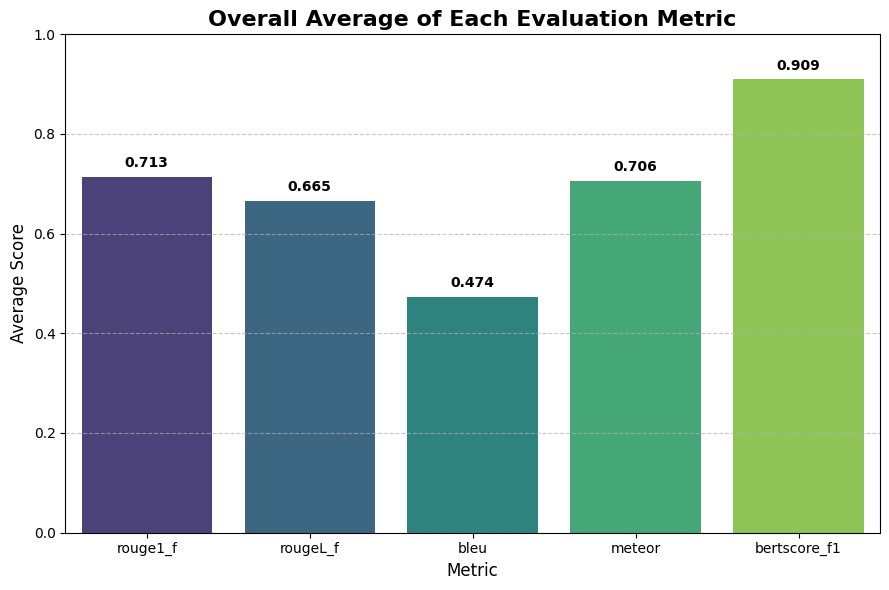

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate overall averages for each metric (only the ones you have!)
overall_averages = metrics_df[['rouge1_f', 'rougeL_f', 'bleu', 'meteor', 'bertscore_f1']].mean()

# Plot
plt.figure(figsize=(9, 6))
barplot = sns.barplot(
    x=overall_averages.index,
    y=overall_averages.values,
    palette='viridis'
)
plt.title('Overall Average of Each Evaluation Metric', fontsize=16, weight='bold')
plt.ylabel('Average Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: Add value labels on top of bars
for i, v in enumerate(overall_averages.values):
    barplot.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

BIRADS Prediction

In [ ]:
def extract_breast_birads_from_text(report_text):
    lines = report_text.splitlines()
    in_opinion = False
    side = None
    result = {"left": None, "right": None}

    for line in lines:
        stripped = line.strip()
        if not stripped:
            continue

        if stripped.startswith("OPINION:"):
            in_opinion = True
            continue
        if not in_opinion:
            continue

        if stripped.startswith("Right Breast:"):
            side = "right"
        elif stripped.startswith("Left Breast:"):
            side = "left"
        elif side and "(BIRADS" in stripped:
            m = re.search(r"\(BIRADS\s+(\d)\)", stripped)
            if m:
                result[side] = int(m.group(1))
                side = None  # reset after match

    return result

In [ ]:
import os
import pandas as pd

# ---- STEP 1: Ground truth from patient_jsons (Excel → JSON) ----
def build_ground_truth_df(patient_jsons, patient_ids):
    """
    Build a DataFrame with one row per (patient, breast).
    Columns: patient_id, side ('L' or 'R'), true_birads
    """
    rows = []
    for pid in patient_ids:
        pj = patient_jsons[pid]

        # Left breast
        true_left = pj["left"].get("birads_value")
        if true_left is not None:
            rows.append({
                "patient_id": pid,
                "side": "L",
                "true_birads": int(true_left),
            })

        # Right breast
        true_right = pj["right"].get("birads_value")
        if true_right is not None:
            rows.append({
                "patient_id": pid,
                "side": "R",
                "true_birads": int(true_right),
            })

    return pd.DataFrame(rows)


# ---- STEP 2: Predictions from generated DOCX reports ----
from docx import Document

def docx_to_text(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs)

def build_predictions_df(gen_dir, patient_ids):
    """
    Build a DataFrame with one row per (patient, breast).
    Columns: patient_id, side ('L' or 'R'), predicted_birads
    Uses your extract_breast_birads_from_text() helper.
    """
    rows = []
    for pid in patient_ids:
        gen_path = os.path.join(gen_dir, f"P{pid}_report.docx")
        if not os.path.exists(gen_path):
            print(f"Skipping {pid}: generated DOCX not found")
            continue

        gen_text = docx_to_text(gen_path)
        pred = extract_breast_birads_from_text(gen_text)

        # Left breast prediction
        if pred.get("left") is not None:
            rows.append({
                "patient_id": pid,
                "side": "L",
                "predicted_birads": int(pred["left"]),
            })

        # Right breast prediction
        if pred.get("right") is not None:
            rows.append({
                "patient_id": pid,
                "side": "R",
                "predicted_birads": int(pred["right"]),
            })

    return pd.DataFrame(rows)


# Build both tables for your TEST set
gt_df = build_ground_truth_df(patient_jsons, test_ids)
pred_df = build_predictions_df(GEN_DIR, test_ids)

print("Ground truth rows:", len(gt_df))
print("Prediction rows:", len(pred_df))
display(gt_df.head())
display(pred_df.head())

Ground truth rows: 88
Prediction rows: 88


,patient_id,side,true_birads
0,4,L,1
1,4,R,1
2,13,R,3
3,14,L,1
4,14,R,4


,patient_id,side,predicted_birads
0,4,L,1
1,4,R,1
2,13,R,2
3,14,L,1
4,14,R,4


In [ ]:
# ---- STEP 3: Align and evaluate (per breast instance) ----
def align_and_evaluate(gt_df, pred_df):
    # Merge on patient_id AND side so L/R are separate instances
    merged = pd.merge(
        gt_df, pred_df,
        on=["patient_id", "side"],
        how="inner"
    )

    print("Total breast-level instances in merged data:", len(merged))

    y_true = merged["true_birads"].tolist()
    y_pred = merged["predicted_birads"].tolist()

    # Optional sanity check: how many unique patients / sides
    print("Unique patients:", merged["patient_id"].nunique())
    print("Sides count:", merged["side"].value_counts().to_dict())

    return y_true, y_pred, merged

y_true, y_pred, merged_df = align_and_evaluate(gt_df, pred_df)


Total breast-level instances in merged data: 88
Unique patients: 50
Sides count: {'L': 45, 'R': 43}


In [ ]:
# Diagnostic: Check coverage of (patient, side) pairs
expected_pairs = {(pid, side) for pid in test_ids for side in ["L", "R"]}
gt_pairs       = set(zip(gt_df["patient_id"], gt_df["side"]))
pred_pairs     = set(zip(pred_df["patient_id"], pred_df["side"]))
merged_pairs   = set(zip(merged_df["patient_id"], merged_df["side"]))

missing_in_gt   = expected_pairs - gt_pairs
missing_in_pred = expected_pairs - pred_pairs
missing_in_merged = expected_pairs - merged_pairs

print(f"Total expected breast instances: {len(expected_pairs)}")
print(f"Ground truth available:          {len(gt_pairs)}")
print(f"Predictions extracted:           {len(pred_pairs)}")
print(f"Successfully aligned (merged):   {len(merged_pairs)}\n")

if missing_in_gt:
    print("Missing in ground truth (no 'birads_value' in JSON):")
    print("   ", sorted(missing_in_gt))
if missing_in_pred:
    print("Missing in predictions (BIRADS not found in DOCX report):")
    print("   ", sorted(missing_in_pred))
if missing_in_merged:
    print("Missing in final evaluation (either GT or pred missing):")
    print("   ", sorted(missing_in_merged))

Total expected breast instances: 100
Ground truth available:          88
Predictions extracted:           88
Successfully aligned (merged):   88

Missing in ground truth (no 'birads_value' in JSON):
    [(13, 'L'), (17, 'L'), (23, 'L'), (41, 'R'), (48, 'R'), (53, 'L'), (58, 'R'), (112, 'R'), (120, 'R'), (151, 'R'), (175, 'L'), (217, 'R')]
Missing in predictions (BIRADS not found in DOCX report):
    [(13, 'L'), (17, 'L'), (23, 'L'), (41, 'R'), (48, 'R'), (53, 'L'), (58, 'R'), (112, 'R'), (120, 'R'), (151, 'R'), (175, 'L'), (217, 'R')]
Missing in final evaluation (either GT or pred missing):
    [(13, 'L'), (17, 'L'), (23, 'L'), (41, 'R'), (48, 'R'), (53, 'L'), (58, 'R'), (112, 'R'), (120, 'R'), (151, 'R'), (175, 'L'), (217, 'R')]


# Note: 12 breasts excluded due to missing BIRADS in source data (likely non-assessable)

OR they have it only on one side of the breast

Confusion Matrix (rows = true, cols = predicted):
 [[31  0  0  0  0]
 [ 5 12  0  0  0]
 [ 2  3  2  0  0]
 [ 2  0  2  9  0]
 [ 0  1  0  0 19]]


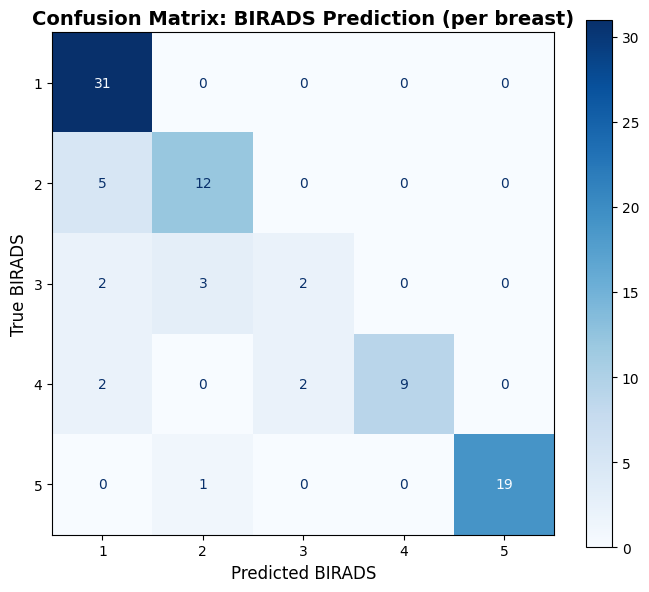


 Classification Report:
              precision    recall  f1-score   support

    BIRADS 1       0.78      1.00      0.87        31
    BIRADS 2       0.75      0.71      0.73        17
    BIRADS 3       0.50      0.29      0.36         7
    BIRADS 4       1.00      0.69      0.82        13
    BIRADS 5       1.00      0.95      0.97        20

    accuracy                           0.83        88
   macro avg       0.81      0.73      0.75        88
weighted avg       0.83      0.83      0.82        88



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# ---- STEP 4: Confusion matrix + metrics ----
def generate_confusion_matrix_and_report(y_true, y_pred):
    # Force labels to be [1, 2, 3, 4, 5] — standard BI-RADS categories
    LABELS = [1, 2, 3, 4, 5]

    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    print("Confusion Matrix (rows = true, cols = predicted):\n", cm)

    # Plot
    plt.figure(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
    plt.title("Confusion Matrix: BIRADS Prediction (per breast)", fontsize=14, weight='bold')
    plt.xlabel("Predicted BIRADS", fontsize=12)
    plt.ylabel("True BIRADS", fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Classification report (with zero_division=0 to avoid warnings for missing classes)
    print("\n Classification Report:")
    print(classification_report(
        y_true, y_pred,
        labels=LABELS,
        target_names=[f"BIRADS {l}" for l in LABELS],
        zero_division=0
    ))

# Call it
generate_confusion_matrix_and_report(y_true, y_pred)


In [ ]:
import pandas as pd

def build_acr_ground_truth_df(patient_jsons, patient_ids):
    """
    One row per patient: patient_id, true_acr (A/B/C/D).
    Uses the 'density_overall' field from your JSON.
    """
    rows = []
    for pid in patient_ids:
        pj = patient_jsons[pid]
        acr = pj.get("density_overall", None)

        if acr is not None and str(acr).strip() != "":
            rows.append({
                "patient_id": pid,
                "true_acr": str(acr).strip().upper()
            })
        else:
            print(f"[GT] Missing ACR for patient {pid}")

    return pd.DataFrame(rows)

acr_gt_df = build_acr_ground_truth_df(patient_jsons, test_ids)
print("ACR ground truth rows:", len(acr_gt_df))
display(acr_gt_df.head())


[GT] Missing ACR for patient 13
[GT] Missing ACR for patient 14
[GT] Missing ACR for patient 17
[GT] Missing ACR for patient 23
[GT] Missing ACR for patient 41
[GT] Missing ACR for patient 48
[GT] Missing ACR for patient 53
[GT] Missing ACR for patient 58
[GT] Missing ACR for patient 80
[GT] Missing ACR for patient 112
[GT] Missing ACR for patient 120
[GT] Missing ACR for patient 136
[GT] Missing ACR for patient 143
[GT] Missing ACR for patient 151
[GT] Missing ACR for patient 173
[GT] Missing ACR for patient 175
[GT] Missing ACR for patient 184
[GT] Missing ACR for patient 186
[GT] Missing ACR for patient 217
[GT] Missing ACR for patient 236
[GT] Missing ACR for patient 309
[GT] Missing ACR for patient 320
ACR ground truth rows: 28


,patient_id,true_acr
0,4,C
1,16,C
2,45,B
3,50,B
4,64,C


In [ ]:
import re

def extract_acr_from_text(text: str):
    """
    Extract overall ACR breast density category (A/B/C/D) from radiology report.

    Looks for patterns like:
      - "ACR: B"
      - "ACR B"
      - "ACR-2"
      - "breast density (ACR C)"

    Returns: str in {'A', 'B', 'C', 'D'} or None if not found.
    """
    if not text or not isinstance(text, str):
        return None

    # Case-insensitive search for ACR + letter/number
    # \b = word boundary, \s* = optional spaces, [:\-\s] = colon, dash, or space after
    match = re.search(r"\bACR\s*([A-D1-4])\b", text, re.IGNORECASE)

    if not match:
        return None

    raw_val = match.group(1).strip().upper()

    # Map numeric ACR (1-4) to letters (A-D)
    num_to_letter = {"1": "A", "2": "B", "3": "C", "4": "D"}
    return num_to_letter.get(raw_val, raw_val)  # returns raw_val if already A-D


In [ ]:
def build_acr_predictions_df(gen_dir, patient_ids):
    """
    Extract ACR predictions from generated DOCX reports.
    Returns DataFrame: patient_id, pred_acr
    """
    rows = []
    for pid in patient_ids:
        gen_path = os.path.join(gen_dir, f"P{pid}_report.docx")
        if not os.path.exists(gen_path):
            print(f"[ACR PRED] Skipping {pid}: DOCX not found")
            continue

        text = docx_to_text(gen_path)
        pred_acr = extract_acr_from_text(text)

        if pred_acr in {"A", "B", "C", "D"}:
            rows.append({"patient_id": pid, "pred_acr": pred_acr})
        else:
            print(f"[ACR PRED] No valid ACR found in report for {pid}")

    return pd.DataFrame(rows)

# Run it!
acr_pred_df = build_acr_predictions_df(GEN_DIR, test_ids)
print("ACR prediction rows:", len(acr_pred_df))
display(acr_pred_df.head())

[ACR PRED] No valid ACR found in report for 23
[ACR PRED] No valid ACR found in report for 151
[ACR PRED] No valid ACR found in report for 184
[ACR PRED] No valid ACR found in report for 186
ACR prediction rows: 46


,patient_id,pred_acr
0,4,C
1,13,C
2,14,B
3,16,C
4,17,B


In [ ]:
# Merge on patient_id
acr_merged = pd.merge(
    acr_gt_df,
    acr_pred_df,
    on="patient_id",
    how="inner"
)

print(f"ACR evaluation pairs: {len(acr_merged)} / {len(test_ids)} patients")
display(acr_merged.head())

ACR evaluation pairs: 28 / 50 patients


,patient_id,true_acr,pred_acr
0,4,C,C
1,16,C,C
2,45,B,B
3,50,B,B
4,64,C,C


ACR Prediction Accuracy: 1.0


<Figure size 600x500 with 0 Axes>

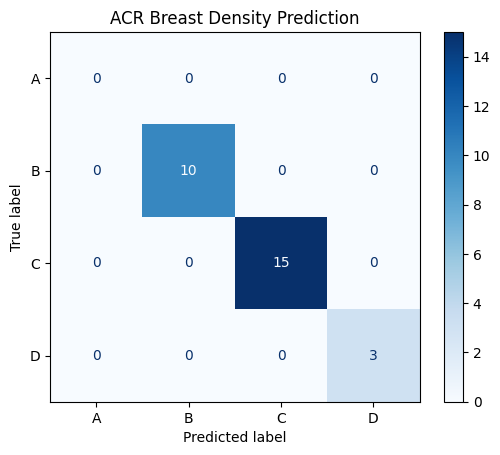

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

if len(acr_merged) > 0:
    y_true_acr = acr_merged["true_acr"]
    y_pred_acr = acr_merged["pred_acr"]

    print("ACR Prediction Accuracy:", accuracy_score(y_true_acr, y_pred_acr))

    # Confusion matrix (A→D)
    cm_acr = confusion_matrix(y_true_acr, y_pred_acr, labels=["A", "B", "C", "D"])
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_acr, display_labels=["A", "B", "C", "D"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("ACR Breast Density Prediction")
    plt.grid(False)
    plt.show()
else:
    print("No ACR pairs to evaluate!")